---
# <h1 style="color:olive;"><b>1 - Library</b></h1>

In [ ]:
#!pip install opencv-python numpy face_recognition face_recognition_models scikit-image deepface mediapipe

In [ ]:
#!pip install matplotlib diffusers transformers accelerate safetensors torch pillow

In [ ]:
#!pip install facenet-pytorch retina-face dlib

In [ ]:
'''!pip uninstall diffusers torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio
!pip install diffusers==0.35.2'''

In [1]:
!python --version

Python 3.10.19


In [1]:
import argparse
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import face_recognition
import torch
import pandas as pd
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

from GetFaceFunc import (get_subset_from_zip, abv_avg_quality_randomizer)
from FaceColorFunc import (get_face_mask, shift_skin_color, change_face_color)
#from EvalFace import FaceDetected, close_face_detectors

/home/derpy/Documents/Fac/M.IA/a1/s1/IAS/.venv/lib/python3.10/site-packages/face_recognition_models/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/derpy/Documents/Fac/M.IA/a1/s1/IAS/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-29 23:12:09.667066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

---

# <h1 style="color:olive;"><b>2 - GET DATASET</b></h1>

### to remove/alter

Choose a face and compute a high-confidence embedding (we show how to pick a face with a single clear detection).

Dataset: UTKFace (easiest + labeled by ethnicity) imgs are classified [age]_[gender]_[race]_[date&time].jpg

Sample size: 50 (10 White, 10 Black, 10 Asian, 10 Indian, 10 Latino)

Control: Same sex, similar age range (20–30)

Use case: Color variation bias experiment

Ethical note: Only public research datasets, no scraped Google images

## <h2 style="color:olive;"><b>Baseline Dataset</b></h2> 

In this stage of the ptoject, a baseline image dataset is constructed using the **UTKFace dataset**, a publicly available facial image dataset commonly used for research in facial recognition, demographic analysis and computer vision.
The UTKFace dataset contains over 22 000 face images labeled accordinge to age, gender, race and date&time in the filename format: [age]_[gender]_[race]_[date&time].jpg
- [age]: integer form 0 to 116, indicating age
- [gender]: either 0(male) or 1(female)
- [race]: integer from 0 to 4, denoting White, Black, Asian, Indian, and Others(like Hispano, Latino, Middle Eastern)
- [date&time]: format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

Regarding data use and ethics, the UTKFace dataset is distributed for non-commercial, academic research purposes, and includes images collected under fair-use principles. While the dataset contains real human faces, its usage is generally considered legally permissible provided it is handled responsibly, with appropriate anonymization and without any attempt to identify or misuse the individuals depicted.

In [ ]:
# --- Configs --- #
df_path = r"C:/Users/Daniela/Desktop/Fac/M.IA/ano_1/semestre_1/IAS/Projeto_Individual/UTKFace_zipedfolder.zip"

filteed_folder = "../UTK_filtered"
target_age_range = (28, 34)
target_gender = 0 
SAMPLE_SIZE = 10

In [3]:
get_subset_from_zip(df_path, filteed_folder, target_age_range, target_gender)

Found 2197 images of (28 to 34)-year-old male.
 Successfully extracted 2197 images to '../UTK_filtered'


2197

Whilst verifying the imported image dataset, it was found that a small subset of images was misclassified. Some of those fotos were incorrectrly labeled in terms of gender(female images appeared on the male category) and ethnicity(Black individuals categorized under the 'White' group)  

To ensure higher data accuray and consistency, it was added a manual process were any obvious outliars were removed. It was also removed any black and white only foto.


### to remove

Note: even though India is in Asia, due to the glaringly diferenceds noticed between Arabians, Indians, Russians to the rest of Asia (Indonisia, China, Mongolia,...) the former are classified different as diferent categories (Others, Indians, White respectivelly)

filtering “high-quality” images per race
Measure image quality — usually by sharpness (variance of Laplacian) or brightness/contrast balance.

In [ ]:
# now add part where u get avrg img quality per group and choose random 10 form img that are above avrg quality
# those imgs will have their names saved


## <h2 style="color:olive;"><b>2.2 - FairFace df </b></h2> 

In [ ]:
#%pip install datasets 

- age - in groups: 0 '0-2', 1 '3-9', 2 '10-19', 3 '20-29', 4 '30_39', 5 '40-49', 6 '50-59', 7 '60-69',
- gender - 0 Male, 1 Female
- race - 0 East Asian, 1 Indian, 2 Black, 3 White, 4 Middle Eastern, 5 Latino_Hispanic, 6 Southeast Asian
- service test - True, False

| Variant  | Meaning                                     | Typical use                                     |
| -------- | ------------------------------------------- | ----------------------------------------------- |
| *"1.25"* | **Higher-resolution images** (larger scale) | Better visual detail, higher accuracy potential |
| *"0.25"* | **Lower-resolution images** (downscaled)    | Faster training, lower memory usage             |


In [2]:
from datasets import load_dataset

dataset = load_dataset("HuggingFaceM4/FairFace", "0.25")

In [3]:
print(dataset)
print(".............................\n")
print(f"each row of the df has 5 values:")
dataset['train'][0]

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})
.............................

each row of the df has 5 values:


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'age': 6,
 'gender': 0,
 'race': 0,
 'service_test': True}

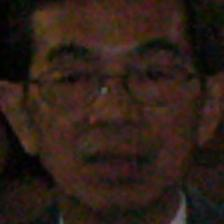

In [4]:
face_foto = dataset['train'][0]['image']
face_foto

In [5]:
def pil_to_rgb_np(img_pil, style = "RGB"):
    """
    Converts PIL Image to NumPy uint8 array in the requested color style
    (e.g., 'RGB', 'L', 'RGBA').
    """
    return np.array(img_pil.convert(style))

face_foto_rgb = pil_to_rgb_np(face_foto)
face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

---

# <h1 style="color:olive;"><b>3 - FACIAL PAINT</b></h1>

## <h2 style="color:olive;"><b>Alter Skin Pigmentation</b></h2> 


1-> creating a second img (mask) with only the skin and every other pixel as 0,0,0, than, (to get the this I was thinking of using something like Mediapipe Face Mesh (from Google), BiSeNet for face parsing, DeepLab / U²-Net for general segmentation) 

2-> in the mask, shift the pixels towords the color chosen (maby do like a vector with the lightes pixel to the chosen green and than apply that same vector onto the rest of the pixels getting various shades of green acording to the diference on the light/shade) I don't know if vectors are a good way, I dont know how colour shifts work, if not by matrix than get the most comon pixel colour of the skin as the chosen colour, and the diviations of the other like being darker or slightly more red become something like a darker green or a more yellowish green

*if you work in Lab color space, the hue/lightness balance will stay more realistic than raw RGB.*

3-> afterwards fuse the two, swap the 0,0,0 with values of the mask with values from the same position from the img

| Step            | Feasibility            | Comment                             |
| --------------- | ---------------------- | ----------------------------------- |
| 1. Segmentation | ✅ Very feasible        | Use BiSeNet or Mediapipe.           |
| 2. Color shift  | ✅ Feasible and elegant | Work in Lab space for best results. |
| 3. Fusion       | ✅ Easy                 | Use alpha blending with mask.       |


In [2]:
test_face_c= "../Color_Change" #where to store the imgs
os.makedirs(test_face_c, exist_ok=True)

# ------- FOR NOW TEST 1 IMG --------- #

img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError(f"Could not read image from {img_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
padded = cv2.copyMakeBorder(img_rgb, 40, 40, 40, 40, cv2.BORDER_REFLECT)


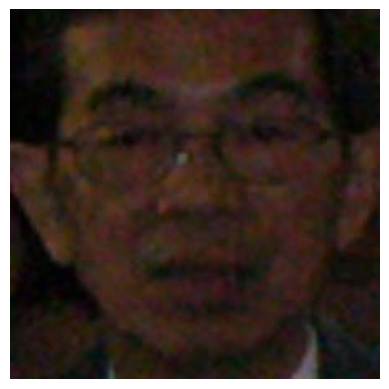

In [13]:
plt.imshow(face_foto_rgb) #img_rgb  #padded cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.show()

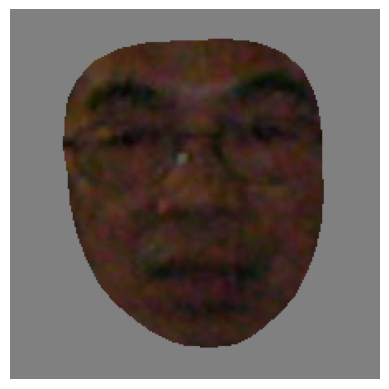

In [14]:
masked_face = get_face_mask(face_foto_rgb)
#print(masked_face)
plt.imshow(masked_face)
plt.axis("off")
plt.show()

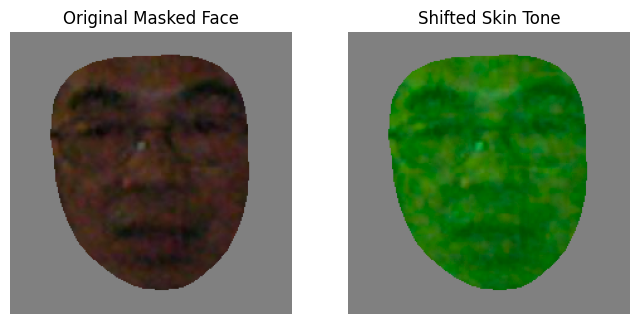

In [44]:
colored_face_mask, _ = shift_skin_color(masked_face, (0,110,0))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(masked_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(colored_face_mask); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

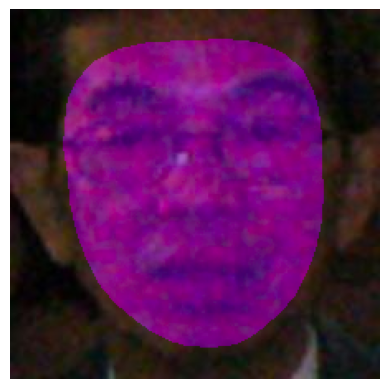

In [45]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128)) #img_bgr
plt.imshow(oainted_face)
plt.axis("off")
plt.show()

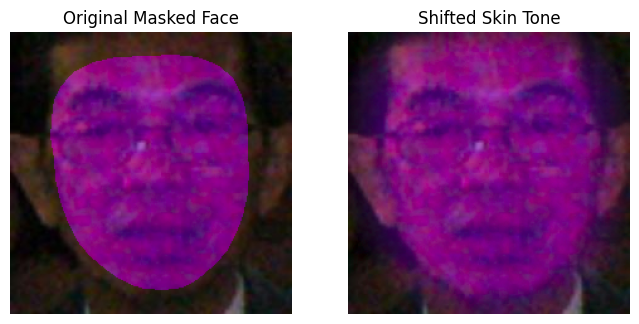

In [46]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128))
oainted_face_blur = change_face_color(img = face_foto_bgr, color = (128, 0, 128), smooth = 15)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(oainted_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(oainted_face_blur); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

Problem -> too diff

option 1 (lazy) -> for all images, both normal and altered use only the mask of recognizable face, find the mean of the pixels colors and shift it a little to grey, use this new one as background

option 2 (not so easy) -> the pixels close and on the borderlines gets teir colours mixed. Mimiking a little what the kernel on the CNNs does but applied only on the borders of the face 

| Option                       | Description              | Quality      | Speed   | Complexity | Best For           |
| ---------------------------- | ------------------------ | ------------ | ------- | ---------- | ------------------ |
| 1️⃣ Background harmonization | Shift background color   | 🟡 Medium    | ⚡ Fast  | 🟢 Easy    | Quantitative tests |
| 2a️ Gaussian feather        | Soft transition edges    | 🟢 High      | ⚡ Fast  | 🟢 Easy    | All-rounder        |
| 2b️ Distance fade           | Control fade width       | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Custom look        |
| 2c️ Poisson clone           | Gradient-level blending  | 🟣 Excellent | 🐢 Slow | 🔴 Hard    | Visual realism     |
| 3️⃣ Lightness matching       | Adjust L channel locally | 🟢 High      | ⚡ Fast  | 🟡 Medium  | Natural look       |


In [ ]:
"""
This method takes too much time
...and faild first try
"""

import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

# load the pretrained Stable Diffusion 2.1 model
model_id = "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)


# open your input image (replace with your file path)
img_path = "../UTK_filtered/white/29_0_0_20170109002204936.jpg.chip.jpg"#28_0_0_20170104202019890.jpg.chip.jpg 
init_image = Image.open(img_path).convert("RGB")

# the creative prompt
prompt = "the same person but with natural looking green skin, realistic lighting, detailed skin texture, cinematic portrait"

# adjust strength: 0.3–0.6 = subtle; 0.7+ = big change
result = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.5,
    guidance_scale=8.0
).images[0]

#result.save("green_skin_output.png")
#print("✅ Saved output to green_skin_output.png")

plt.imshow(result)
plt.axis("off")
plt.show()


c:\Users\Daniela\Desktop\Fac\M.IA\ano_1\semestre_1\IAS\Projeto_Individual\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daniela\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...:  17%|█▋        | 1/6 [

: 

| Goal                                 | Method                              | Function                     |
| ------------------------------------ | ----------------------------------- | ---------------------------- |
| Rough face box                       | `face_recognition.face_locations()` | Rectangle mask               |
| Detailed outline                     | `face_recognition.face_landmarks()` | Polygon mask (jawline, etc.) |
| True pixel mask (skin vs background) | Mediapipe / segmentation model      | Requires external library    |


| Method                     | Type                  | Accuracy                                                    | Speed       | Comments                                            |
| -------------------------- | --------------------- | ----------------------------------------------------------- | ----------- | --------------------------------------------------- |
| **Mediapipe Face Mesh**    | Landmark-based        | ✅ Good for face contours, eyes, lips                        | ⚡ Very fast | Doesn’t explicitly label “skin” vs “hair”           |
| **BiSeNet (Face Parsing)** | Semantic segmentation | ⭐ Excellent — directly gives skin, eyes, mouth, hair labels | 🐢 Slower   | Requires model weights, but great for research      |
| **U²-Net / DeepLab**       | General segmentation  | Medium                                                      | Medium      | Not face-specific — can confuse hair and background |


### <h2 style="color:olive;"><b>3.1 Chose color palet</b></h2>

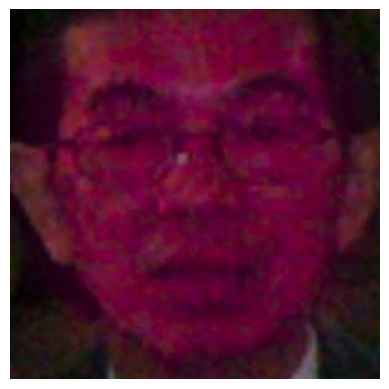

In [10]:
#Test set -> visually analyse color of choosing

oainted_face_blur = change_face_color(img = face_foto_bgr, color = (102, 0, 51), smooth = 15)
plt.imshow(oainted_face_blur)
plt.axis("off")
plt.show()

In [6]:
#(102, 51, 0), #orange
#(51, 25, 0), # orange dark

palet = [
    ("Red", (102, 0, 0), "light"), # Red
    ("Red", (51, 0, 0), "dark"), # Red, dark 
    ("yellow", (102, 102, 0), "light"), # yellow
    ("yellow", (51, 51, 0), "dark"), # yellow dark
    ("green", (0, 102, 0), "light"), # green
    ("green", (0, 51, 0), "dark"), # green dark
    ("blue", (0, 102, 102), "light"), # blue (mix)
    ("blue", (0, 51, 51), "dark"), # blue (mix) dark
    ("indigo", (0, 0, 102), "light"), # indigo
    ("indigo", (0, 0, 51), "dark"), # indigo dark
    ("roxo", (102, 0, 102), "light"), #roxo
    ("roxo", (51, 0, 51), "dark"), #roxo dark
    ]


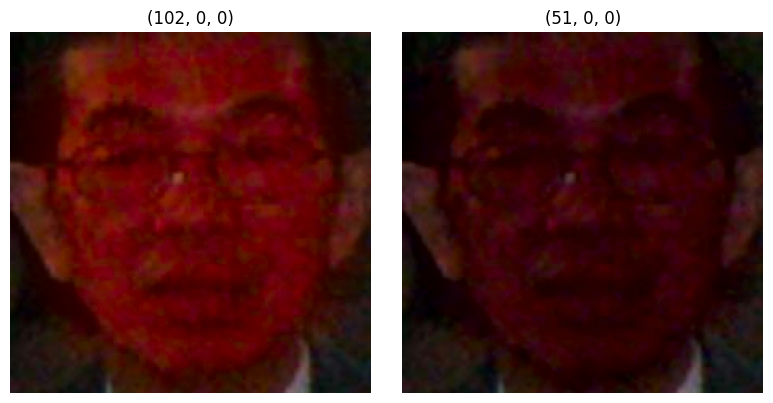

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, p in zip(axes, palet[:2]):
    painted = change_face_color(
        img=face_foto_bgr,
        color=p,
        smooth=15
    )
    ax.imshow(painted)
    ax.set_title(str(p))
    ax.axis("off")

plt.tight_layout()
plt.show()


---
# <h1 style="color:olive;"><b> 4 - Facial Recogniton</b></h1>

<h3><b>Overvew:</b></h3>

Several Face Recognition Models will be tested to check how different training sets can influence unseen skin characteristics

The models to be testes are:
- MediaPipe;          “Balanced-ish” (≈ FairFace)
- MTCNN Mixed;        (≈ UTK / DiF)
- RetinaFace;         VGGFace2-like
- Dlib HOG;           Biased baseline

This where trained with differently balanced dfs:
- FairFace (most balanced df)
- UTK (not as balanced but the second lowes rate of whites, small race division)
- DiF (simmilar to UTK but with more 'race' variety)
- VGG2 (higly unbalanced)

the results will be stored in a df
columns
| COLUMNS                                 | DESCRIPTION                              | 
| ------------------------------------ | ----------------------------------- | 
| id | simmilar to the og imgs id but with new sufix of the faces color |
| old_img_id | the base imgs id |
| age | the age of the person in the foto |
| sex | the sex (male, female) |
| race | the og mg defined race |
| color | the new color of the individuals face |
| shade | lighter shade of color or darker shade |
| FR_model | the face recognition model used |
| y | the resuts of the given img by the chosen FR_model |


do per model 
- for same colour but diff tonalities
- check the diff clours toghether 
- compare lighter and darker tones
- compare same colours but different races

off all models 
- check ability to predict

In [7]:
oainted_face_blur = change_face_color(img = face_foto_bgr, color = (128, 0, 128), smooth = 15)
print(FaceDetected(face_foto_bgr))
print(FaceDetected(oainted_face_blur))


[True, True, True]
[True, True, True]


In [ ]:
FR_list = ["mediapipe", "dlib_hog", "mtcnn"]

rows = []

start_idx = 13336
stop_idx = 50000
subset = dataset["train"].select(range(start_idx, stop_idx))
#for idx, row in enumerate(dataset["train"][start_idx:], start=start_idx): #dataset["train"]

for idx, row in enumerate(subset, start=start_idx):
    print(f"curr id =\n ---> {idx}")

    # --- Base metadata ---
    base_id = idx
    age = row["age"]
    sex = row["gender"]      # adjust if encoded (0/1)
    race = row["race"]

    # --- Load image ---
    face_foto_rgb = pil_to_rgb_np(row["image"])
    face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

    # --- Iterate over recolorings ---
    for color_name, color_rgb, shade in palet:
        painted_face = change_face_color(
            img=face_foto_bgr,
            color=color_rgb,
            smooth=15
        )

        if painted_face is None:
            continue

        # --- Run face recognition models ---
        detections = FaceDetected(painted_face, FR_list)

        rows.append({
            "id": f"{base_id}_{color_name}_{shade}",
            "old_img_id": base_id,
            "age": age,
            "sex": sex,
            "race": race,
            "color": color_name,
            "shade": shade,
            f"y_{FR_list[0]}": int(detections[0]),
            f"y_{FR_list[1]}": int(detections[1]),
            f"y_{FR_list[2]}": int(detections[2]),
        })
 
close_face_detectors()


In [10]:
df = pd.DataFrame(rows)
print(df.head())

               id  old_img_id  age  sex  race   color  shade  y_mediapipe  \
0     0_Red_light           0    6    0     0     Red  light            1   
1      0_Red_dark           0    6    0     0     Red   dark            1   
2  0_yellow_light           0    6    0     0  yellow  light            1   
3   0_yellow_dark           0    6    0     0  yellow   dark            0   
4   0_green_light           0    6    0     0   green  light            0   

   y_dlib_hog  y_mtcnn  
0           1        1  
1           0        1  
2           1        1  
3           1        1  
4           1        0  


In [ ]:
print(df.iloc[-1])

id             13335_Red_dark
old_img_id              13335
age                         1
sex                         0
race                        2
color                     Red
shade                    dark
y_mediapipe                 1
y_dlib_hog                  1
y_mtcnn                     1
Name: 149101, dtype: object


In [17]:
i = 13335
for i in range(13335,13339):
    print(i)

13335
13336
13337
13338


In [11]:
df.to_csv("face_detection_results.csv", index=False)

---
# <h1 style="color:olive;"><b>5 - Results Analysis </b></h1>

this part is for analysis of the results_df, it's purpose is to visualize how the diferent colors impacted the facial recognition networks, what colors have hiher fail rate, define how much the models depend on color to identify faces (if all people have same facial color is there still a diference in accoracy between races? and if so is it the same, smaller or greater? is there a diference between same untrained colors but different sexes? does color have diferent impacts in differen age groups?)

## <h2 style="color:olive;"><b>5.1 - DataSet Cleaning </b></h2>

In [3]:
df_1 = pd.read_csv("face_detection_results.csv")
print(df_1.head())
df_2 = pd.read_csv("face_detection_results_p2.csv")
print(df_2.head())

               id  old_img_id  age  sex  race   color  shade  y_mediapipe  \
0     0_Red_light           0    6    0     0     Red  light            1   
1      0_Red_dark           0    6    0     0     Red   dark            1   
2  0_yellow_light           0    6    0     0  yellow  light            1   
3   0_yellow_dark           0    6    0     0  yellow   dark            0   
4   0_green_light           0    6    0     0   green  light            0   

   y_dlib_hog  y_mtcnn  
0           1        1  
1           0        1  
2           1        1  
3           1        1  
4           1        0  
                   id  old_img_id  age  sex  race   color  shade  y_mediapipe  \
0     13336_Red_light       13336    3    0     0     Red  light            1   
1      13336_Red_dark       13336    3    0     0     Red   dark            1   
2  13336_yellow_light       13336    3    0     0  yellow  light            1   
3   13336_yellow_dark       13336    3    0     0  yellow   dar

In [8]:
df = pd.concat([df_1, df_2])
print(f"columns={df.columns}\n{df.iloc[-1]}")
df.head()

columns=Index(['id', 'old_img_id', 'age', 'sex', 'race', 'color', 'shade',
       'y_mediapipe', 'y_dlib_hog', 'y_mtcnn'],
      dtype='object')
id             49998_roxo_dark
old_img_id               49998
age                          4
sex                          0
race                         5
color                     roxo
shade                     dark
y_mediapipe                  1
y_dlib_hog                   0
y_mtcnn                      0
Name: 411479, dtype: object


,id,old_img_id,age,sex,race,color,shade,y_mediapipe,y_dlib_hog,y_mtcnn
0,0_Red_light,0,6,0,0,Red,light,1,1,1
1,0_Red_dark,0,6,0,0,Red,dark,1,0,1
2,0_yellow_light,0,6,0,0,yellow,light,1,1,1
3,0_yellow_dark,0,6,0,0,yellow,dark,0,1,1
4,0_green_light,0,6,0,0,green,light,0,1,0



alter some of the columns values so as to make them more understandable when analysing

In [9]:

d_sex={0: 'Male',
       1: 'Female'}
d_race={0: 'East_Asian',
        1: 'Indian',
        2: 'Black',
        3: 'White',
        4: 'Middle Eastern',
        5: 'Latino_Hispanic',
        6: 'Southeast_Asian'}
d_age={0:'0-2',
       1:'3-9',
       2:'10-19',
       3:'20-29',
       4:'30-39',
       5:'40-49',
       6:'50-59',
       7:'60-69',
       }

df['sex'] = df['sex'].map(d_sex)
df['race'] = df['race'].map(d_race)
df['age'] = df['age'].map(d_age)

In [10]:
df.head()

,id,old_img_id,age,sex,race,color,shade,y_mediapipe,y_dlib_hog,y_mtcnn
0,0_Red_light,0,50-59,Male,East_Asian,Red,light,1,1,1
1,0_Red_dark,0,50-59,Male,East_Asian,Red,dark,1,0,1
2,0_yellow_light,0,50-59,Male,East_Asian,yellow,light,1,1,1
3,0_yellow_dark,0,50-59,Male,East_Asian,yellow,dark,0,1,1
4,0_green_light,0,50-59,Male,East_Asian,green,light,0,1,0


<h3 style="color:olive;"><b>TO DO </b></h3>
check the missing ids (when diff between 2 rows is greater than 1, there are missing ids, plot all missing ids)

In [11]:
def generalScoreModel(df: pd.DataFrame, col_list: list[str], color: list[str] = None, y_list: list[str] = ["y_mediapipe", "y_dlib_hog", "y_mtcnn"]) -> None:
    """
    Description:
        Given a dataframe and two lists of column names,
        calculates the percentage of binary values for each column in y_list per combination of col_list
        and plots the result as side-by-side bars in a grouped bar chart.

    ------------------
    Parameters:
        df: pd.DataFrame
            A dataframe that contains columns with the same names as the ones in both col_list and y_list.
        col_list: list[str]
            List of column names that will be aggregated to represent different x-values.
        y_list: list[str], optional
            The columns must be binary.
            The percentage of their value per different col_list combination will be represented by the y-axis.
        color: list[str], optional
            A list of hex color codes to use for the bars. If not provided, default colors will be used.

    -----------
    Returns:
        None
            Plots a grouped bar graph of the percentage of y_list instances per combination of col_list.
    """
    #color_l = ["#73E048", "#4AF7E9", "#E04FFF"]
    if color is not None:
        # Fail check: the number of colors should match the number of y_list columns
        if len(color) != len(y_list):
            raise ValueError(f"The number of colors ({len(color)}) must match the number of y_list columns ({len(y_list)}).")
        colors = color
    else:
        colors = None  
    
    grouped_df = df.groupby(col_list)[y_list].sum()

    total_count = df.groupby(col_list).size()  # Total number of rows for each combination of col_list
    percent_df = grouped_df.div(total_count, axis=0) * 100  # Percentage calculation

    #################################
    p_percent_df = pd.DataFrame() 
    diff_columns = []
    for i in range(len(y_list)):
        for j in range(i + 1, len(y_list)):
            col_name = f'diff_{y_list[i]}_vs_{y_list[j]}'
            diff_columns.append(col_name)
            p_percent_df[col_name] = percent_df[y_list[i]] - percent_df[y_list[j]]
    ###################################
    print("\nPercentage Table (Percentage of Binary Values per Combination of col_list and y_list):")
    print(percent_df)
    print("\nPercentage Table (Difference between 2 diferent columns):")
    print(p_percent_df)

    # ----- PLOT ----- #
    ax = percent_df.plot(kind='bar', figsize=(12, 7.5), color=colors, width=0.8)  # `width=0.8` makes space between bars
    
    ax.set_xlabel('Combinations of ' + ', '.join(col_list))
    ax.set_ylabel('Percentage (%) of Binary Values')
    ax.set_title('Grouped Bar Chart of Y-List Columns per Combination of X-List Columns')

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()
    
    return None




Percentage Table (Percentage of Binary Values per Combination of col_list and y_list):
                 y_mediapipe  y_dlib_hog    y_mtcnn
race                                               
Black              91.872508   57.393987  63.284600
East_Asian         95.630994   66.972396  68.612676
Indian             92.788438   65.978730  71.099212
Latino_Hispanic    93.812198   66.421300  69.160276
Middle Eastern     90.747924   59.997278  68.577310
Southeast_Asian    95.263789   65.330593  68.565148
White              92.097685   60.296754  66.326239

Percentage Table (Difference between 2 diferent columns):
                 diff_y_mediapipe_vs_y_dlib_hog  diff_y_mediapipe_vs_y_mtcnn  \
race                                                                           
Black                                 34.478521                    28.587908   
East_Asian                            28.658598                    27.018318   
Indian                                26.809708                  

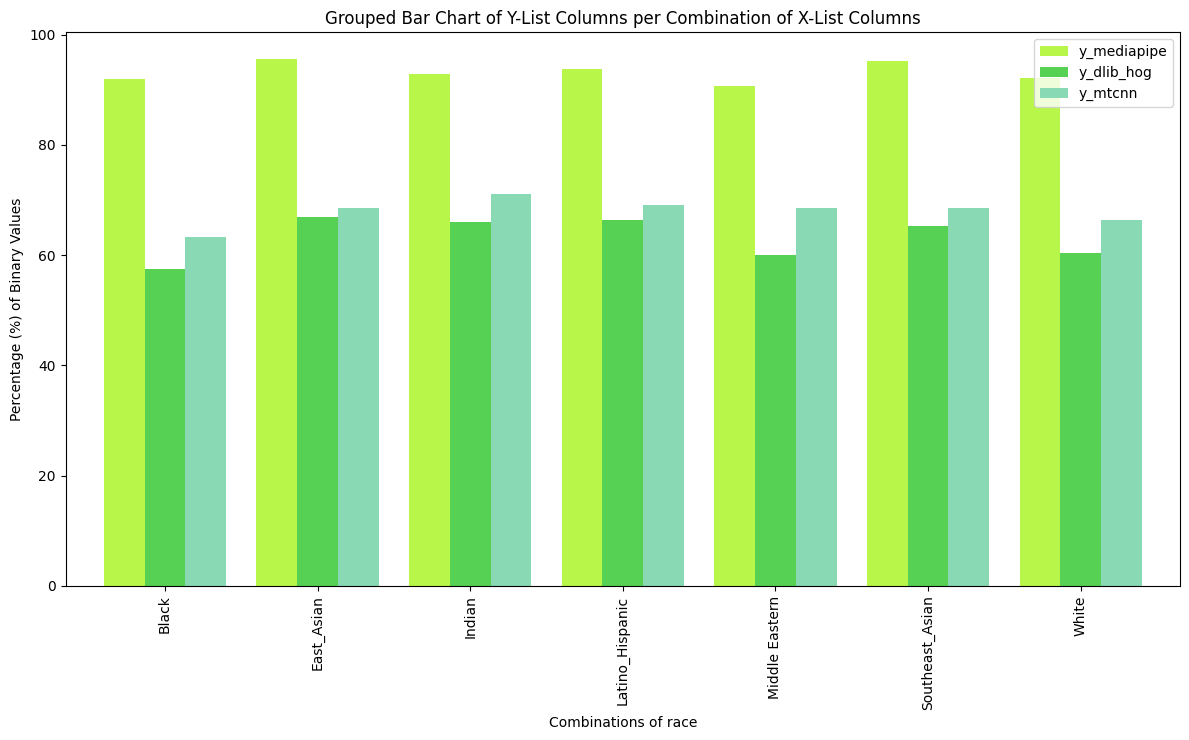

In [12]:
c_l = ["#B8F74A", "#57D154", "#89D9B4"]
generalScoreModel(df=df, col_list=['race'], color=c_l)

all races were painted the same colors so, provided collor is the only thing that matters, results should be somewhat identicle,
dlib and mtcnn showed simmilar patterns, small discrepencies on the success rate of each race, the most notorious cases where `Middle Eastern` and surprinsingly `White`. 
`East_Asian` was the one that reach the highest detection value (95.63%) secconed by `Southeast_Asian`.
Althogh White was the race that , when training the models was most predominant, none of the models had it as the highest percentual value when with different colors


Percentage Table (Percentage of Binary Values per Combination of col_list and y_list):
        y_mediapipe  y_dlib_hog    y_mtcnn
color                                     
Red       92.365571   52.254046  90.493621
blue      94.424703   73.428235  64.651611
green     92.138499   70.042813  13.261265
indigo    89.045275   47.635663  78.003853
roxo      94.192444   60.849834  88.172964
yellow    96.937814   74.960933  72.580542

Percentage Table (Difference between 2 diferent columns):
        diff_y_mediapipe_vs_y_dlib_hog  diff_y_mediapipe_vs_y_mtcnn  \
color                                                                 
Red                          40.111525                     1.871950   
blue                         20.996468                    29.773092   
green                        22.095687                    78.877234   
indigo                       41.409611                    11.041421   
roxo                         33.342609                     6.019480   
yellow      

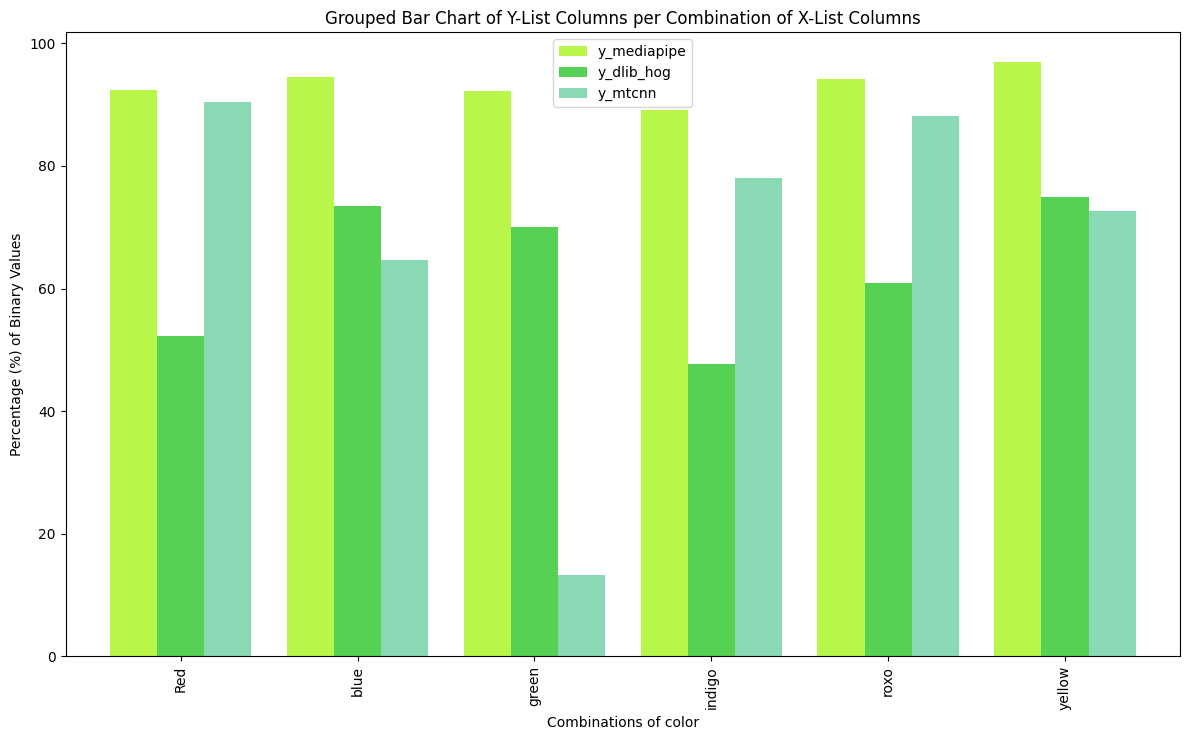

In [14]:
generalScoreModel(df=df, col_list=['color'], color=c_l)

although mediapipe seams to be able to properlly adapt to new colors without much problem (great atribut for when a foto is take in a place without withe light) the other models, spetially mtcnn struggled with this new adaptation. This difference in succes rate between the models, potentially indicates for heavy reliance on colors for both dlib and mtcnn, where as mediapipe probably uses with more importance other features.

Dlib hog, dispit being the oficial 'worst' model, manadge to outranke mtcnn on `Blue`, `Yellow` and `Green`

Mtcnn was particularlly bad with `Green` identifying only 13.3% of faces


Percentage Table (Percentage of Binary Values per Combination of col_list and y_list):
              y_mediapipe  y_dlib_hog    y_mtcnn
shade sex                                       
dark  Female    95.284047   62.773151  67.334617
      Male      92.494822   54.806253  66.534973
light Female    94.316825   71.402770  70.223595
      Male      90.912446   64.453619  67.504221

Percentage Table (Difference between 2 diferent columns):
              diff_y_mediapipe_vs_y_dlib_hog  diff_y_mediapipe_vs_y_mtcnn  \
shade sex                                                                   
dark  Female                       32.510896                    27.949430   
      Male                         37.688569                    25.959849   
light Female                       22.914055                    24.093229   
      Male                         26.458827                    23.408226   

              diff_y_dlib_hog_vs_y_mtcnn  
shade sex                                 
dark  Fema

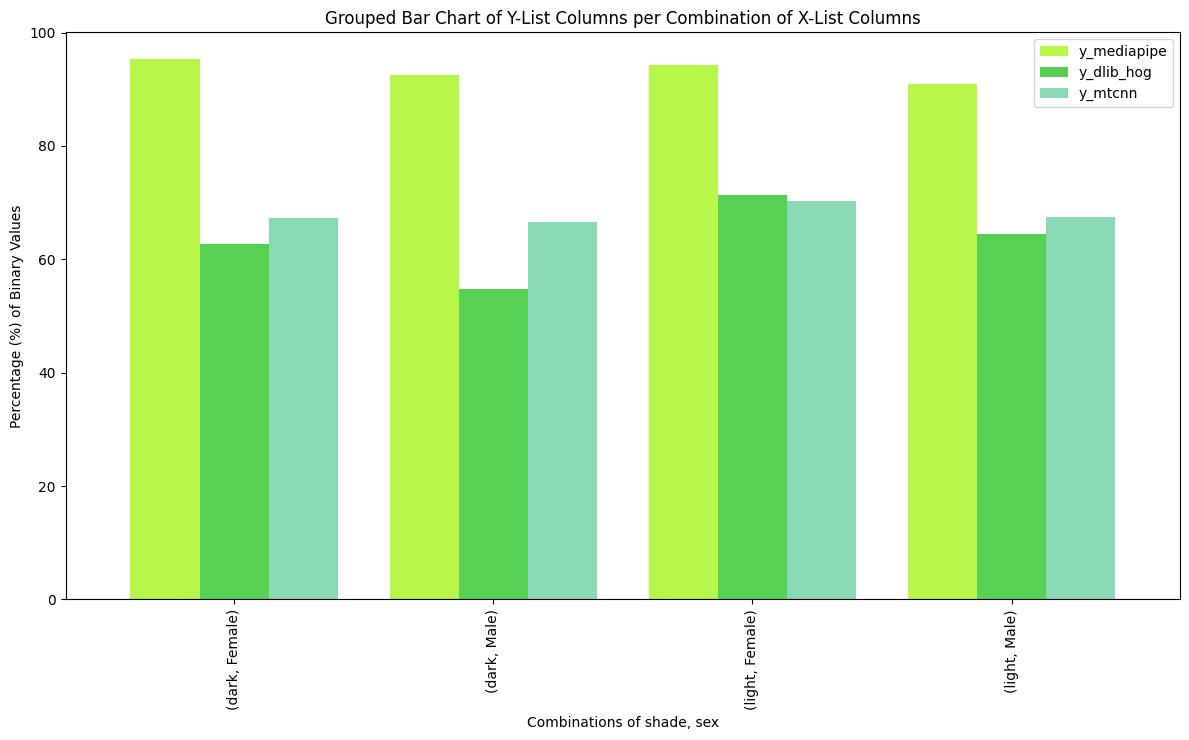

In [16]:
generalScoreModel(df=df, col_list=['shade','sex'], color=c_l)

**Mediapipe** was the only model that was able to obtain a higher score with darker tones.
The lowes score was from **dlib hog** on `dark` and `male` failing almos half of the images (almost 17% lower than its best performer of `light` and `female`)

In general the models have higer success at identifying female faces compared to male ones(compare this results the ones using only normal skin pigmentations)

Interesting note is that dlib hog managed to outperform mtcnn if the image was `female` and `light` skin tone


Percentage Table (Percentage of Binary Values per Combination of col_list and y_list):
       y_mediapipe  y_dlib_hog    y_mtcnn
age                                      
0-2      97.090730   53.706443  65.080539
10-19    94.982842   64.066521  69.779912
20-29    93.576326   64.786479  69.701071
3-9      96.103394   62.172419  67.738794
30-39    92.080418   63.586604  68.493328
40-49    91.238290   62.587454  66.350943
50-59    90.764018   62.360335  64.196669
60-69    90.000000   58.233216  59.199058

Percentage Table (Difference between 2 diferent columns):
       diff_y_mediapipe_vs_y_dlib_hog  diff_y_mediapipe_vs_y_mtcnn  \
age                                                                  
0-2                         43.384287                    32.010191   
10-19                       30.916320                    25.202930   
20-29                       28.789847                    23.875256   
3-9                         33.930975                    28.364600   
30-39        

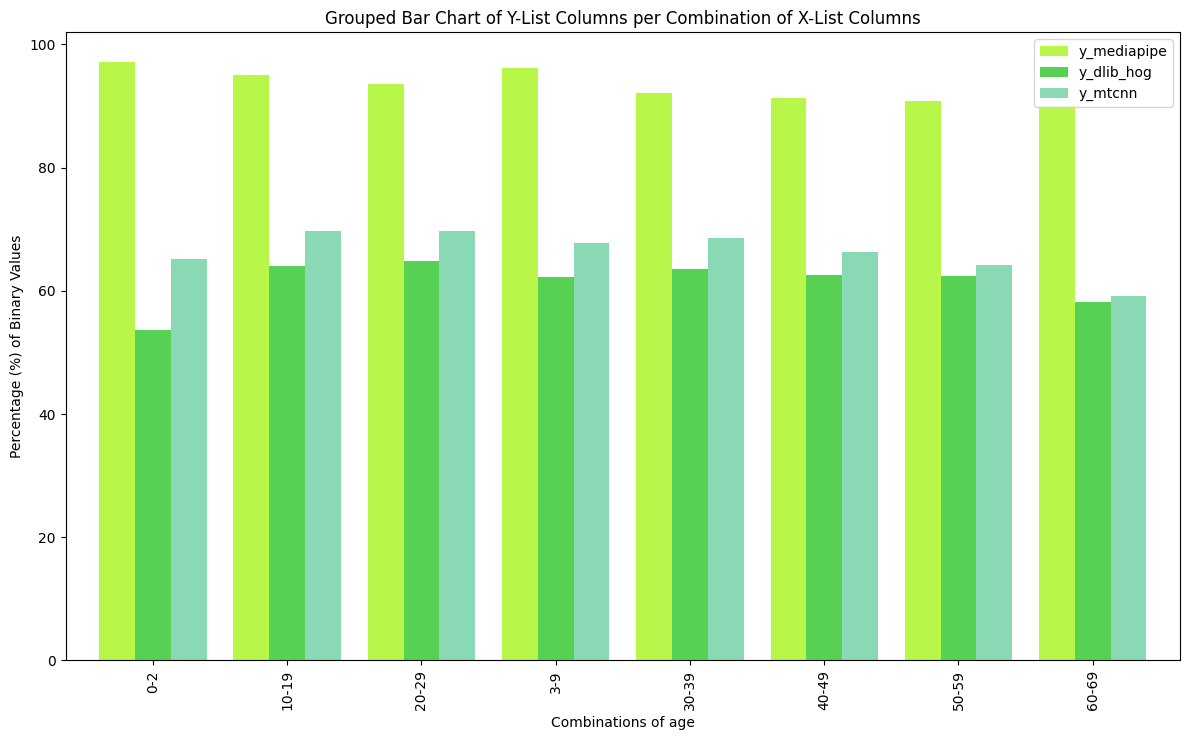

In [17]:
generalScoreModel(df=df, col_list=['age'], color=c_l)

## <h2 style="color:olive;"><b>5.2 - How colors affect each of the other factors </b></h2>

whith age as x and nº fails as y plot:
 
diff shades lighter/darker:
- diff sex (sum of all FR_model) (for each FR_model have its own line)
- diff races (sum of all FR_model) (for each FR_model have its own line) 
- diff races diff sex (sum of all FR_model) (for each FR_model have its own line)

for same shade:
- diff colors (sum of all FR_model) (for each FR_model have its own line)


fazer funcx q plota diff plots per color

In [ ]:
clr_lst=[
    "#F54927",
    "#F87C63",
    "#FCC6BB",
    "#C82909",
    "#701705",
    "#440E03",

    "#F8CB63",
    "#F4AE0B",
    "#D3F527",
    "#C8A509",
    "#9C8107",
    "#839C07",

    "#98FA8F",
    "#38F527",
    "#76F527",
    "#079C0A",
    "#09C816",
    "#409C07",

    "#27F5C5",
    "#63F8F3",
    "#63DAF8",
    "#079C79",
    "#079C97",
    "#09A2C8",

    "#7286E9",
    "#365AF7",
    "#5032F0",
    "#1C36B5",
    "#07229D",
    "#2A0FC2",

    "#C567F4",
    "#B43EEF",
    "#D548E5",
    "#690B98",
    "#4B096D",
    "#5E0F67",
]

def colorShadeColumn(df: pd.DataFrame, col_list: list[str], split: str = "color", color: list[str] = None, y_list: list[str] = ["y_mediapipe", "y_dlib_hog", "y_mtcnn"]) -> None:
    """
    Description:
        Given a dataframe, two lists of column names, and a column to split by,
        calculates the percentage of binary values for each column in y_list per combination of col_list
        for each unique value of the 'split' column and plots the results in subplots.

    ------------------
    Parameters:
        df: pd.DataFrame
            A dataframe that contains columns with the same names as the ones in both col_list and y_list.
        col_list: list[str]
            List of column names that will be aggregated to represent different x-values.
        color: list[str], optional
            A list of hex color codes to use for the bars. If not provided, default colors will be used.
        y_list: list[str], optional
            The columns must be binary.
            The percentage of their value per different col_list combination will be represented by the y-axis.
        split: str
            The column used to split the dataframe into separate subgroups, one plot for each unique value in this column.
    
    -----------
    Returns:
        None
            Plots subplots for each unique value in the 'split' column.
    """
    if split not in df.columns:
        raise ValueError(f"The column '{split}' does not exist in the dataframe.")
    
    # color_l = ["#73E048", "#4AF7E9", "#E04FFF"]
    if color is not None:
        # Fail check: the number of colors should match the number of y_list columns
        if len(color) != len(y_list):
            raise ValueError(f"The number of colors ({len(color)}) must match the number of y_list columns ({len(y_list)}).")
        colors = color
    else:
        colors = None  
    
    unique_splits = df[split].unique()

    fig, axes = plt.subplots(nrows=len(unique_splits), figsize=(12, 7.5 * len(unique_splits)))

    if len(unique_splits) == 1:
        axes = [axes]  # Make sure axes is iterable if there's only one split value

    for ax, split_value in zip(axes, unique_splits):
        subset_df = df[df[split] == split_value]
        
        grouped_df = subset_df.groupby(col_list)[y_list].sum()
        total_count = subset_df.groupby(col_list).size()  # Total number of rows for each combination of col_list
        percent_df = grouped_df.div(total_count, axis=0) * 100  # Percentage calculation
        
        percent_df.plot(kind='bar', ax=ax, color=colors, width=0.8)
        ax.set_title(f"Grouped Bar Chart for Split: {split_value}")
        ax.set_xlabel('Combinations of ' + ', '.join(col_list))
        ax.set_ylabel('Percentage (%) of Binary Values')
        ax.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add gridlines for better readability

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()
    
    return None


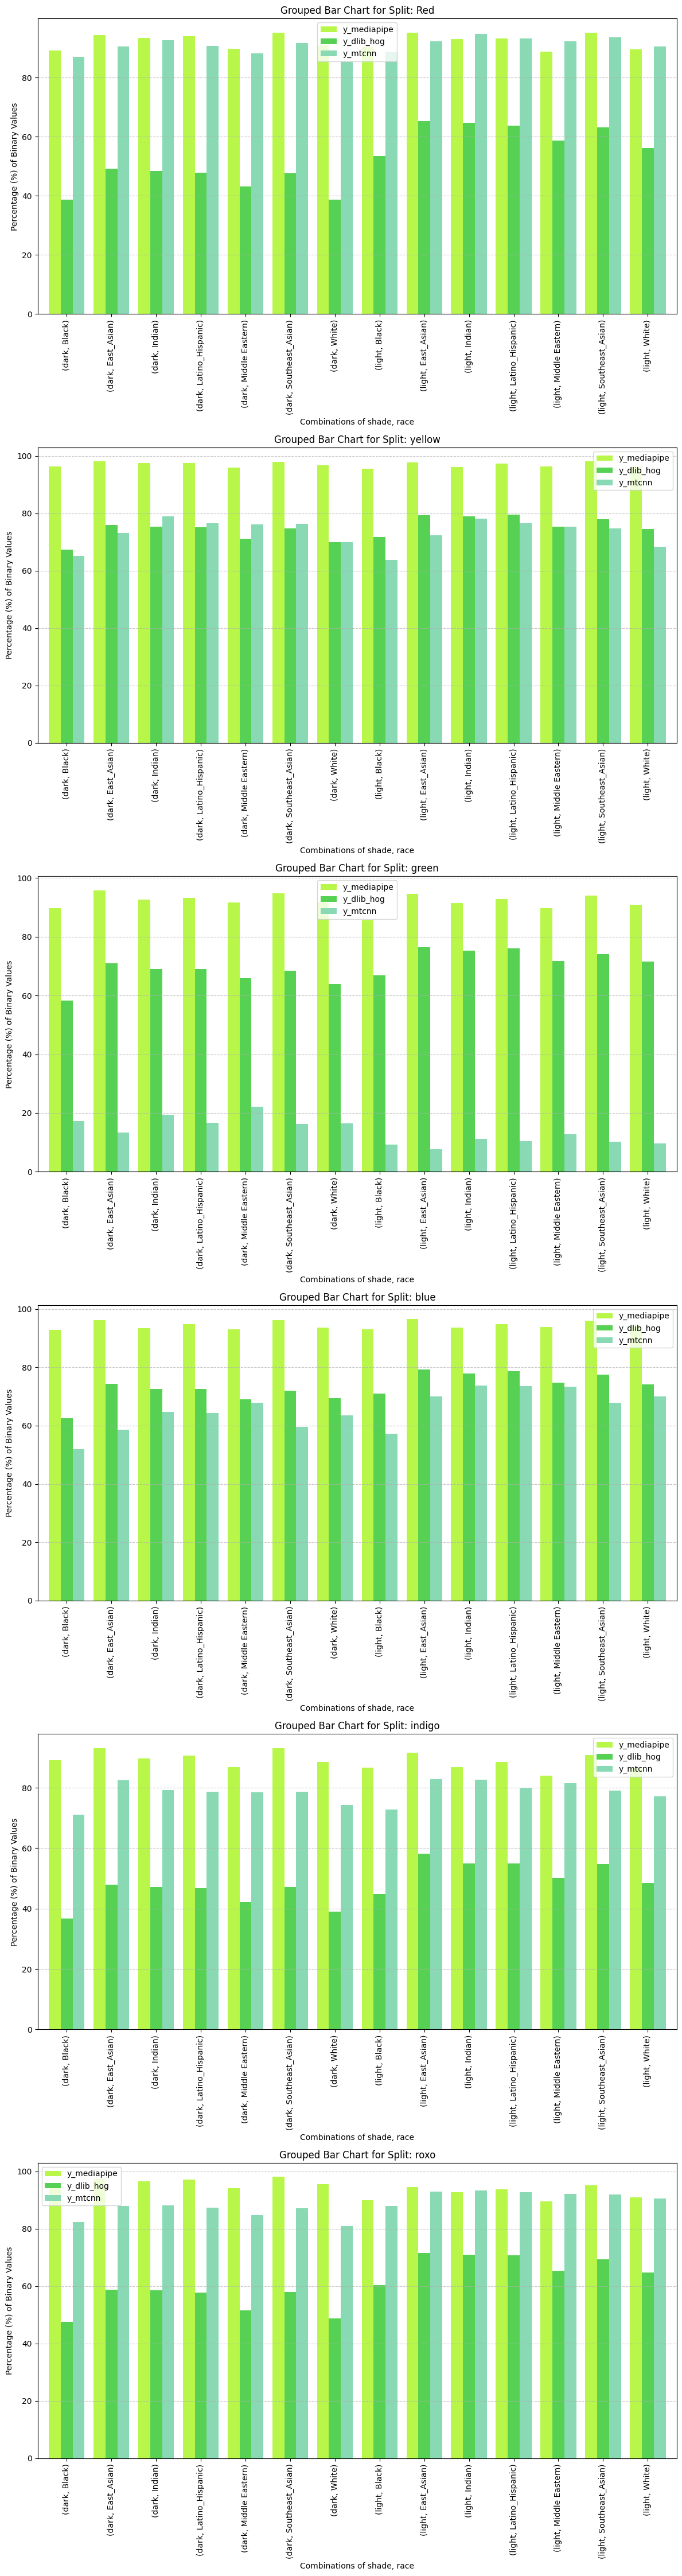

In [32]:
colorShadeColumn(df=df, col_list=['shade', 'race'], split='color', color=c_l)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def colorShadeColumn(df: pd.DataFrame, col_list: list[str], split: str = "color", color: list[str] = None, y_list: list[str] = ["y_mediapipe", "y_dlib_hog", "y_mtcnn"], shade_col: str = "shade") -> None:
    """
    Description:
        Given a dataframe, two lists of column names, and a column to split by,
        calculates the percentage of binary values for each column in y_list per combination of col_list
        for each unique value of the 'split' column and plots the results in subplots with specific color shading.
        
    ------------------
    Parameters:
        df: pd.DataFrame
            A dataframe that contains columns with the same names as the ones in both col_list and y_list.
        col_list: list[str]
            List of column names that will be aggregated to represent different x-values.
        color: list[str], optional
            A list of hex color codes to use for the bars. If not provided, default colors will be used.
        y_list: list[str], optional
            The columns must be binary.
            The percentage of their value per different col_list combination will be represented by the y-axis.
        split: str
            The column used to split the dataframe into separate subgroups, one plot for each unique value in this column.
        shade_col: str
            The column used to determine the "shade" of the color. The function will use this column to distinguish between light and dark combinations.
    
    -----------
    Returns:
        None
            Plots subplots for each unique value in the 'split' column.
    """
    
    clr_lst = {
        'Red': {"dark":["#C82909", "#701705", "#440E03"],
                "light": ["#F54927", "#F87C63", "#FCC6BB"]},
        'yellow': {"light":["#F8CB63", "#F4AE0B", "#D3F527"],
                "dark": ["#C8A509", "#9C8107", "#839C07"]},
        'green': {"light":["#98FA8F", "#38F527", "#76F527"],
                "dark": ["#079C0A", "#09C816", "#409C07"]},
        'blue': {"light":["#27F5C5", "#63DAF8", "#63F8F3"],
                "dark": ["#26997E", "#09A2C8", "#008C88"]},
        'indigo': {"light":["#7286E9", "#365AF7", "#5032F0"],
                "dark": ["#2A41B0", "#07229D", "#3112E3"]},
        'roxo': {"light":["#C567F4", "#B43EEF", "#D548E5"],
                "dark": ["#690B98", "#4B096D", "#5E0F67"]},
    }

    if split not in df.columns:
        raise ValueError(f"The column '{split}' does not exist in the dataframe.")
    
    if shade_col not in df.columns:
        raise ValueError(f"The column '{shade_col}' does not exist in the dataframe.")
    
    unique_splits = df[split].unique()
    
    fig, axes = plt.subplots(nrows=len(unique_splits), ncols=2, figsize=(15, 7.5 * len(unique_splits)))

    if len(unique_splits) == 1:
        axes = [axes]  # Make sure axes is iterable if there's only one split value
    
    for ax_row, split_value in zip(axes, unique_splits):
        shade_l = clr_lst[split_value]["light"]
        shade_d = clr_lst[split_value]["dark"]
        
        # Subset the dataframe based on the split value
        subset_df = df[df[split] == split_value]
        
        # Split the subset by 'shade_col'
        dark_subset = subset_df[subset_df[shade_col] == "dark"]
        light_subset = subset_df[subset_df[shade_col] == "light"]
        
        # Group by the col_list and y_list columns
        dark_grouped = dark_subset.groupby(col_list)[y_list].sum()
        light_grouped = light_subset.groupby(col_list)[y_list].sum()
        
        # Total counts for percentage calculation
        dark_total = dark_subset.groupby(col_list).size()
        light_total = light_subset.groupby(col_list).size()
        
        # Calculate percentage for each group
        dark_percent = dark_grouped.div(dark_total, axis=0) * 100
        light_percent = light_grouped.div(light_total, axis=0) * 100
        
        # Plot dark combinations
        dark_percent.plot(kind='bar', ax=ax_row[0], color=shade_d, width=0.8)
        ax_row[0].set_title(f"Dark Combinations for Split: {split_value}")
        ax_row[0].set_xlabel('Combinations of ' + ', '.join(col_list))
        ax_row[0].set_ylabel('Percentage (%) of Binary Values')
        ax_row[0].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Plot light combinations
        light_percent.plot(kind='bar', ax=ax_row[1], color=shade_l, width=0.8)
        ax_row[1].set_title(f"Light Combinations for Split: {split_value}")
        ax_row[1].set_xlabel('Combinations of ' + ', '.join(col_list))
        ax_row[1].set_ylabel('Percentage (%) of Binary Values')
        ax_row[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    return None


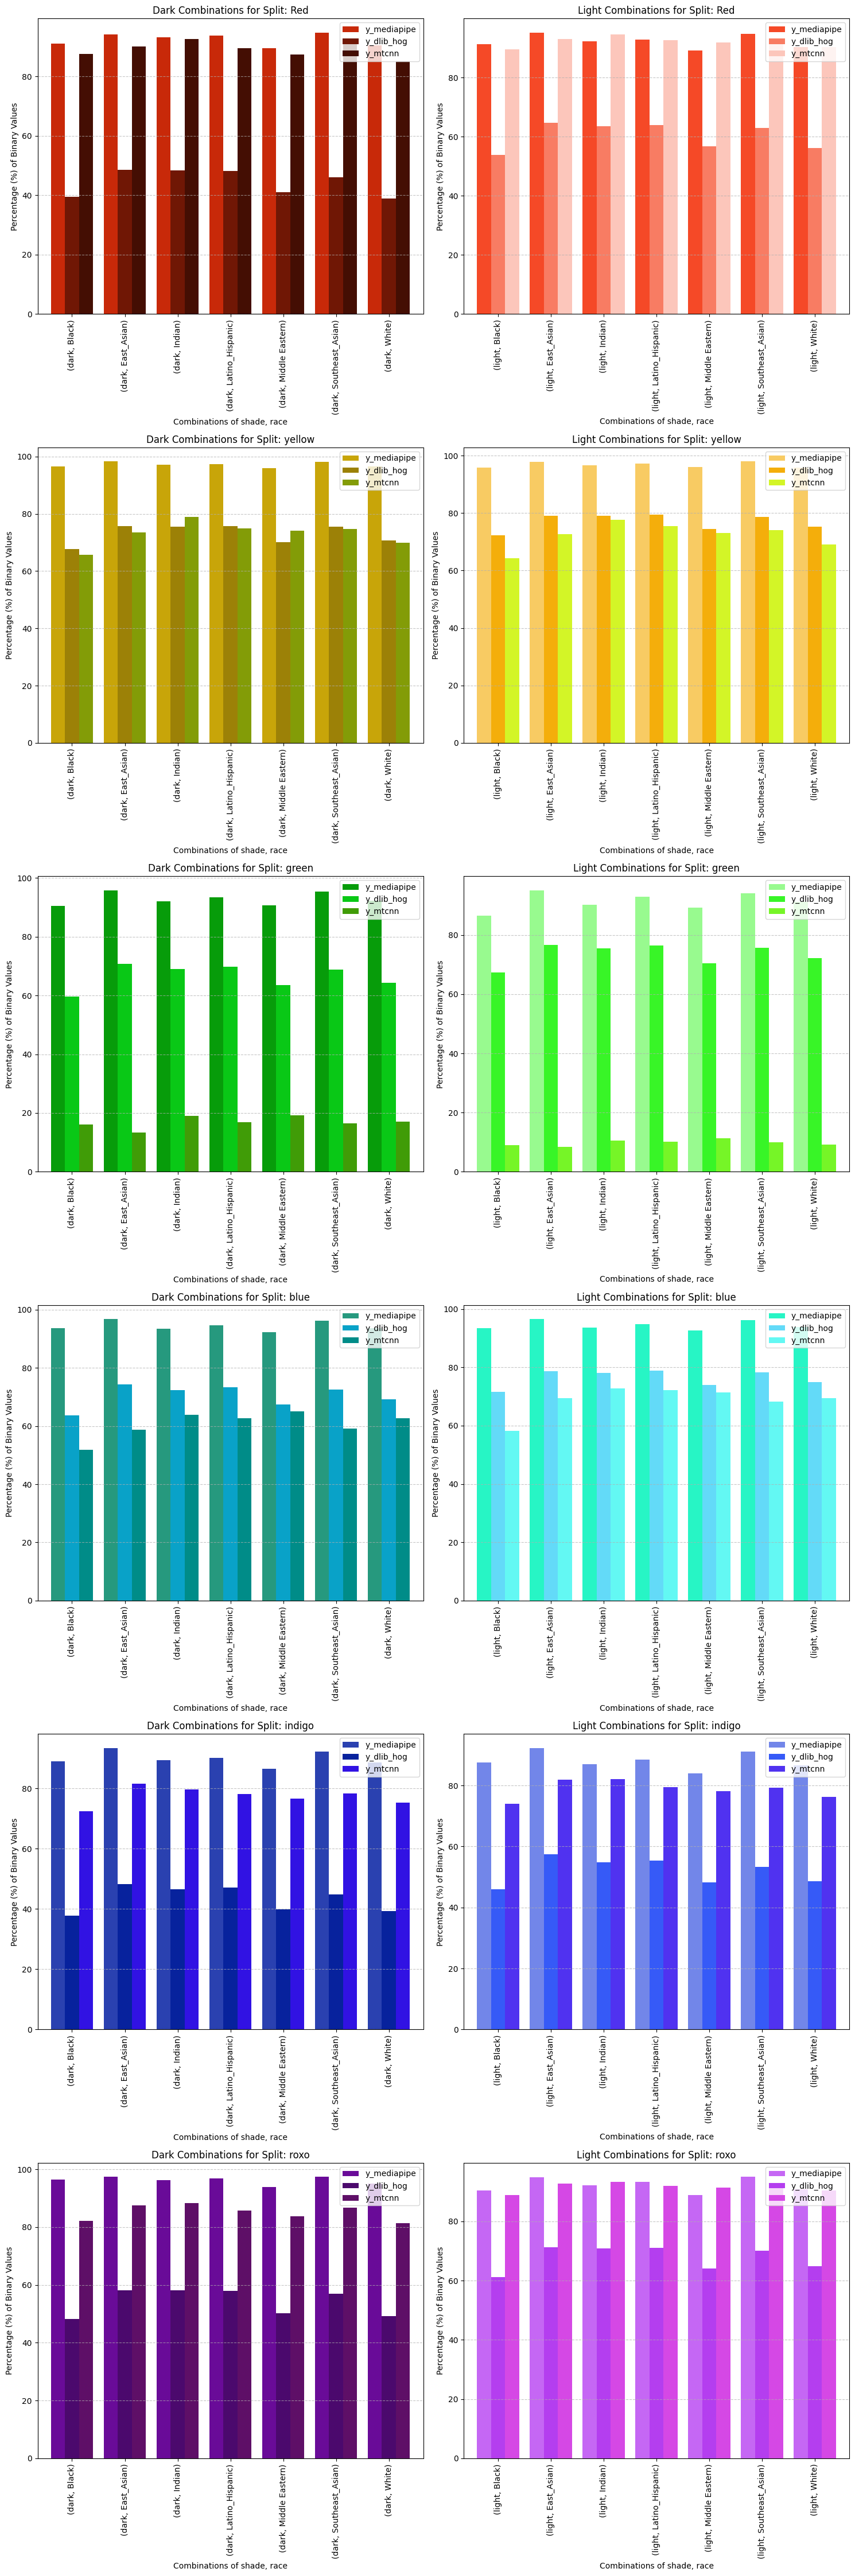

In [35]:
colorShadeColumn(df=df, col_list=['shade', 'race'], split='color', color=clr_lst)

## <h2 style="color:olive;"><b>5.3 -  </b></h2>

---
# <h1 style="color:olive;"><b> 6 - General Takeaway </b></h1>

---

# <h1 style="color:#89F3EA;"><b>7 - EXTRA/FAILURES AND IMPRVMENTS </b></h1>

for facial features (try to eval based on shape of: nose, lips, yeys, chin,...)

on the failed imgs, which ones wher more commonly faled and why they failed (where parts in specific?, lv of confidence)